In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from SyntheticDataModule import *
from estimators import *
from utils import *

,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,1,1000,1.148813,1.139080,1.132147,1.181985,2.272612,2.114850,2.104648,2.212188,1.123799,0.975769,0.972501,1.030203
1,1,1,4000,1.342376,1.413072,1.381042,1.355646,2.354261,2.169431,2.162665,2.404066,1.011884,0.756359,0.781623,1.048421


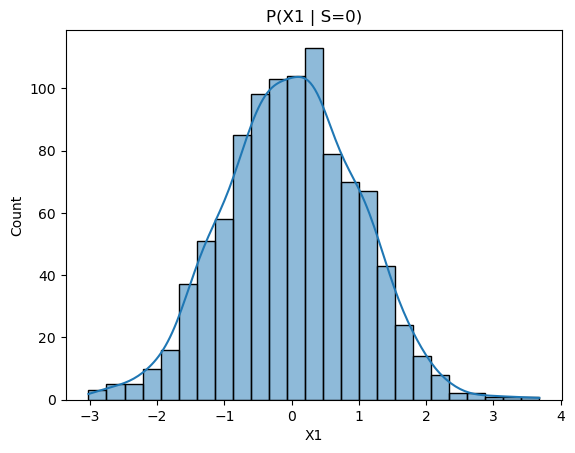

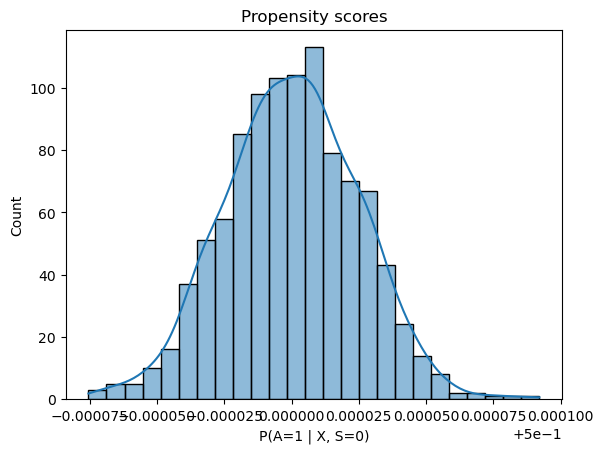

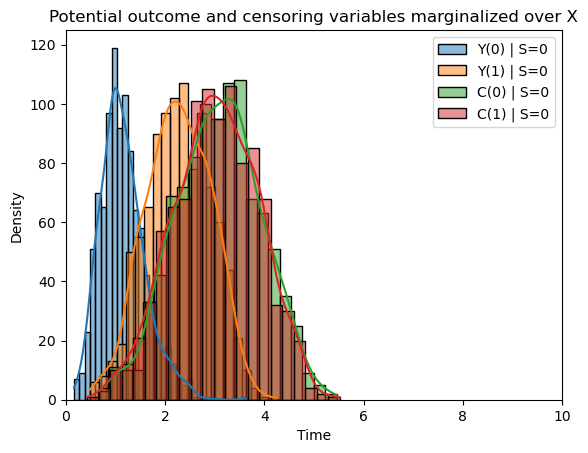

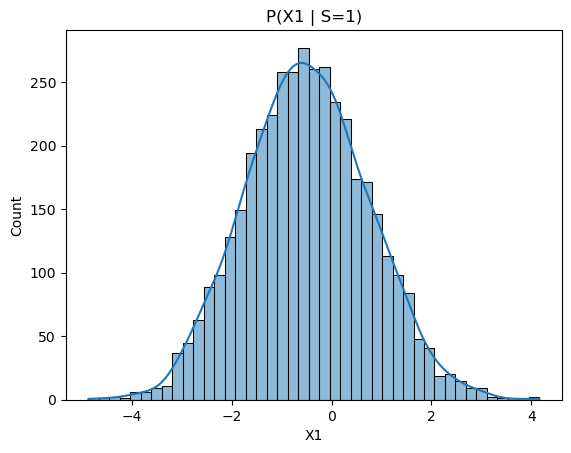

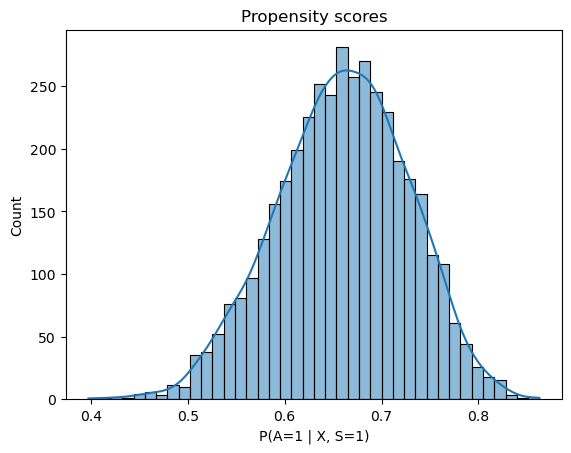

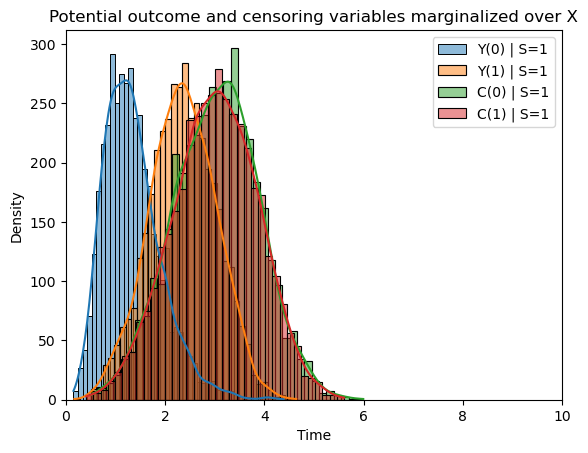

In [2]:
save_df = True
d = 1
rct_size = 1000
m = 4
obs_size = rct_size * m

# RCT data generating model parameters

px_dist_r, px_args_r = 'Gaussian', {'mean': [0], 'cov': [[1]]}
prop_fn_r, prop_args_r = 'sigmoid', {'beta': [0, 1e-4]}
tte_params_r = {'model': 'coxph',
                'hazard': 'weibull',
                'cox_args': {'Y0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                            'Y1': {'beta': [0,0.25], 'lambda': 0.4, 'p': 4},
                            'C0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                            'C1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},
                }

# OBS data generating model parameters

px_dist_o, px_args_o = 'Gaussian', {'mean': [-0.5], 'cov': [[1.5]]}
prop_fn_o, prop_args_o = 'sigmoid', {'beta': [0.8, 0.25]}
tte_params_o = {'model': 'coxph',
                'hazard': 'weibull',
                'cox_args': {'Y0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                            'Y1': {'beta': [0,0.25], 'lambda': 0.4, 'p': 4},
                            'C0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                            'C1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},
                }

RCTData = SyntheticDataModule(save_df, d, rct_size, 0, px_dist_r, px_args_r, prop_fn_r, prop_args_r, tte_params_r)
OBSData = SyntheticDataModule(save_df, d, obs_size, 1, px_dist_o, px_args_o, prop_fn_o, prop_args_o, tte_params_o)

summary_df = pd.concat([RCTData.summary(plot=True), OBSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [3]:
df_rct_oracle, df_rct = RCTData.get_df()
df_obs_oracle, df_obs = OBSData.get_df()

df_combined = pd.concat([df_rct, df_obs], axis=0, ignore_index=True)  # merge the dataframes into one
cov_list = RCTData.get_covs()

df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', cov_list, 'logistic')

df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', cov_list, 'logistic')
df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', cov_list, 'logistic')

gc_est(df_combined, cov_list, tte_model='coxph')

ipcw_est(df_combined, S=0)
ipcw_est(df_combined, S=1)

df_combined

,X0,X1,S,A,T,Delta,P(S=1|X),"P(A=1|X,S)","G_C(T|X,S,A)",S0_ipcw_est_CATE,S0_ipcw_est_Y1,S0_ipcw_est_Y0,S1_ipcw_est_CATE,S1_ipcw_est_Y1,S1_ipcw_est_Y0
0,1.0,1.027589,0,0,1.134867,1,0.718869,0.476602,0.976401,-7.899080,-0.000000,7.899080,0.000000,0.000000,-0.000000
1,1.0,-0.343814,0,0,1.527021,1,0.805573,0.489194,0.948598,-16.208753,-0.000000,16.208753,0.000000,0.000000,-0.000000
2,1.0,0.506691,0,1,1.000328,1,0.754393,0.481382,0.989573,8.549941,8.549941,-0.000000,0.000000,0.000000,-0.000000
3,1.0,-0.964693,0,0,1.102966,1,0.837535,0.494900,0.980972,-13.701528,-0.000000,13.701528,0.000000,0.000000,-0.000000
4,1.0,0.575770,0,0,1.008578,1,0.749860,0.480748,0.985277,-7.881163,-0.000000,7.881163,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,-1.998211,1,0,1.589815,1,0.881188,0.581881,0.957099,0.000000,0.000000,-0.000000,-4.508383,-0.000000,4.508383
4996,1.0,0.387245,1,1,2.636805,0,0.762098,0.713616,0.676428,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
4997,1.0,1.379936,1,1,1.611363,0,0.693144,0.760500,0.943629,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
4998,1.0,1.273518,1,1,1.750818,1,0.701051,0.755735,0.926042,0.000000,0.000000,-0.000000,3.568541,3.568541,-0.000000


In [17]:
test_signals = {'Contrast': ['S0_ipcw_est_CATE', 'S1_ipcw_est_CATE'],
                'Y1': ['S0_ipcw_est_Y1', 'S1_ipcw_est_Y1'],
                'Y0': ['S0_ipcw_est_Y0', 'S1_ipcw_est_Y0'],}


for key_ind, key in tqdm(enumerate(test_signals)):
    print(test_signals[key][0])
    print(key_ind)


3it [00:00, 11449.42it/s]

S0_ipcw_est_CATE
0
S0_ipcw_est_Y1
1
S0_ipcw_est_Y0
2


In [ ]:
save_df = False
B = 100  # num. samples to model the null distribution in every single run

num_exp = 5
m_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # multiplier to get the observational study size.
test_signals = {'Contrast': ['S0_ipcw_est_CATE', 'S1_ipcw_est_CATE'],
                'Y1': ['S0_ipcw_est_Y1', 'S1_ipcw_est_Y1'],
                'Y0': ['S0_ipcw_est_Y0', 'S1_ipcw_est_Y0'],}


mmr_results = np.zeros((len(test_signals), len(m_arr), num_exp))
mmr_pvals = np.zeros((len(test_signals), len(m_arr), num_exp))

for mind, m in enumerate(m_arr):
    obs_size = rct_size * m 

    for nind in tqdm(range(num_exp)):
        RCTData = SyntheticDataModule(save_df, d, rct_size, 0, px_dist_r, px_args_r, prop_fn_r, prop_args_r, tte_params_r)
        OBSData = SyntheticDataModule(save_df, d, obs_size, 1, px_dist_o, px_args_o, prop_fn_o, prop_args_o, tte_params_o)

        df_rct_oracle, df_rct = RCTData.get_df()
        df_obs_oracle, df_obs = OBSData.get_df()

        df_combined = pd.concat([df_rct, df_obs], axis=0, ignore_index=True)  # merge the dataframes into one
        cov_list = RCTData.get_covs()

        # Estimate the nuisance parameters

        df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', cov_list, 'logistic')

        df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', cov_list, 'logistic')
        df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', cov_list, 'logistic')

        gc_est(df_combined, cov_list, tte_model='coxph')

        ipcw_est(df_combined, S=0)
        ipcw_est(df_combined, S=1)

        for kind, key in enumerate(test_signals):
            signal0, signal1 = test_signals[key][0], test_signals[key][1]
            mmr_results[kind, mind, nind], mmr_pvals[kind, mind, nind] = mmr_test(df_combined, cov_list, B, rbf_kernel, signal0, signal1)

In [ ]:
mmr_results

In [ ]:
mmr_pvals

In [ ]:
mmr_pvals.mean(axis=1)

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
obs_oracle_prop = OBSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, obs_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,10,101)
cov_vals = [0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0')
plt.plot(t, tbs_Y1, label='Y1')
plt.plot(t, tbs_C0, label='C0')
plt.plot(t, tbs_C1, label='C1')
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()